# The model

_Martin et al._ uses a combination of models for egg development and thermal hazard. If on day $k$ the temperature is $T_k$, then the egg maturation increases by $\beta T_k + \alpha$, while the thermal hazard increases by $\max(\beta_H (T_k -T_c), 0)$. The egg hatches when the accumulated maturation exceeds 1

This model has both vanishing gradients, and gradient discontinuities, which would make it challanging for any numerical optimization or inference algorithms. It also has a discrete latent parameter, the number of incubation days required for hatching, which makes coding the model in a way that is HMC friendly more complicated.

In addition, the temperature and redd count data that we have is very sparse, being measured at varying intervals of 6-10 days, and it occasionally does not cover the entire reproductive season for a given year. This means that the missing daily temperatures have to be treated as latent parameters, which are assumed to be drawn from the same distribution as the observed ones.

I have tried about a dozen different combinations of equivalent model parametrizations and daily temperature models, and in all cases the end result, after several hours of computation look like this: 

In [22]:
print(fit.stansummary(pars=['temp_crit', 'beta_hazard', 'base_survival', 'mu_egg', 'sigma_egg', 'alpha_egg', 'beta_egg']))

Inference for Stan model: anon_model_7983ae8fdf5538da18ab882212495da9.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

                mean se_mean     sd   2.5%    25%    50%     75%   97.5%  n_eff   Rhat
temp_crit       2.56    0.73   0.73   1.81   1.82   2.56    3.29    3.33      1  55.87
beta_hazard     3.63    0.35   1.57   2.62   3.09   3.29    3.51    10.9     20   1.09
base_survival  -0.58    0.58   0.58  -1.17  -1.17  -0.56 -2.1e-4 -5.1e-5      1   91.4
mu_egg          0.31    0.28   0.28  -0.06   0.05   0.32    0.59    0.59      1  15.63
sigma_egg       0.47    0.17   0.17   0.27   0.31   0.47    0.63    0.69      1  14.63
alpha_egg      -0.67    0.72   0.72  -1.44  -1.39  -0.63    0.06    0.06      1  37.23
beta_egg        0.62    0.54   0.54   0.08   0.08    0.6    1.16    1.19      1  51.78

Samples were drawn using NUTS at Fri Aug 13 13:49:38 2021.
For each parameter, n_eff is a crude measure of effecti

This shows only the egg related parameters, without the ~2500 latent parameters representing missing daily temperatures, because, as I argue in the next section, the situation would still be problematic even if we had all the daily values for temperatures

# Why does this happen?

The short answer is that the model is non-identifiable, i.e. there are infinitelly many pairs of $(\beta_H, T_c)$ pairs that explain a given set of observations equaly well. 

Suppose that an egg is laid on day 1 and the daily temperatures on subsequent days are $T_1, T_2, T_3, \dots$ are all above the critical temperature: $T_k \geq T_c$. The maturation after $n$ day is going to be

$$
M_n = \sum_{k \leq n} \left( \beta T_k + \alpha \right) = \beta \left(\sum_{k \leq n} T_k\right) + \alpha n
$$

Hatching happens at the time $n_* = \inf_n \{M_n \geq 1\}$, that is the samlles $n$ for which $M_n$ exceeds 1. Assuming that $\alpha$ and $\beta$ are small, so that $M_n$ grows in small increments, at the maturation time we have that $M_{n_*} \approx 1$. Plugging this into the previous equation we see that:

$$
\sum_{k \leq n_*} T_k \approx \frac{1 - \alpha n_*}{\beta}
$$

The temperature related hazard incurred before hatching will be:

$$
H_n* = \sum_{k \leq n_*} \beta_H \left( T_k - T_c \right) = \beta_H \left[\left( \sum_{k \leq n_*} T_k \right) - T_c n_*\right] 
     \approx \beta_H \left( \frac{1 - \alpha n_*}{\beta} - T_c n_* \right)
     = \frac{\beta_H}{\beta} - \beta_H \left( \frac{\alpha}{\beta} + T_c \right) n_*
$$

Notice that the total thermal hazard incurred by hatching time depends on the experienced temperatures only indirectly through $n_*$, which is a discrte variable that contains no information about the gradient with respect to the experienced temperatures. This is problematic for gradient based methods, such ast Hamiltonian MCMC, but as we see next, the trouble does not stop here.

Notice that, in the last equation, the dependence on $n_*$ is controlled by the product $\beta_H \left( \frac{\alpha}{\beta} + T_c \right)$. Suppose that $(\beta_H, T_c)$ are a pair of hazard parameters that explain the data well. For any $\gamma > 1$ we can define

$$
\begin{aligned}
\beta_H^{(\gamma)} =& \gamma \beta_H\\
T_c^{(\gamma)} =& \frac{1}{\gamma} T_c + \frac{1 - \gamma}{\gamma} \frac{\alpha}{\beta} 
\end{aligned}
$$

Since $\gamma > 1$, it follows that $\frac{1}{\gamma} < 1$ and $\frac{1 - \gamma}{\gamma} < 0$, and therefore $T_c^{(\gamma)} < T_c$. Hence the assumption that the daily temperatures exceed the critical temperature remains valid for $T_c^{(\gamma)}$, which means that $n_*$ does not change.

Since we have

$$
\beta_H^{(\gamma)} \left( T_c^{(\gamma)} + \frac{\alpha}{\beta} \right) = \gamma \beta_H \left( \frac{1}{\gamma} T_c + \frac{1}{\gamma} \frac{\alpha}{\beta}\right) = \beta_H \left( T_c + \frac{\alpha}{\beta} \right)
$$

or, in other words, the value of $H_{n_*}$ does not change when we go from $(\beta_H, T_c)$ to $(\beta_H^{(\gamma)}, T_c^{(\gamma)})$. This means that in this regime where all the daily temperatures for an egg are above the critical temperature, the model is non-identifiable. Any MCMC algorithm that employs some variation of the Metropolis-Hastings algorithm would eventually try a $T_c$ that is lower than all the observed temperatures and then it would have a high probability of geting trapped exploring its associated $\gamma$-family, which would result in a poor $\hat{R}$ between multiple chains that explore different $\gamma$-families. 

The situation is obviously just as bad if all $T_k < T_c$. There any MCMC proposal that increases $T_c$ will not change $H_{n_*}$. For the case when the observed temperatures $T_k$ fall both above and below $T_c$, the analysis is more complicated. I have a working hypothesis that in that case, if $T^+$ is the smallest of the $T_k$s that is still above $T_c$, and $T^-$ the highest $T_k$ that is below $T_c$, then the limit of the precision with which you can estimate $T_c$ from data is $\Delta T = T^+ - T^-$. I have not managed to prove this yet, but I am confident that I can. 

# Conclusion

This combination of maturation and thermal hazard models is, from a mathematical point of view, not exactly a match made in heaven. In order to precisely measure $T_c$ in the field, which I think is the value of most interest, we would likely need two things:
* daily temperature measurements over the incubation period (this would reduce the number of latent parameters the model has to worry about)
* an informative prior on $\beta_H$.

# Code

In [23]:
import pystan as stan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [25]:
model = stan.StanModel(file='src/model2.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4bb203bd975614654d17b664e5e6d9c3 NOW.


In [26]:
def load_data(surv, obs, temp_reg=0.05, mat_reg=0.01, alpha_egg=0.00056, beta_egg=0.001044, I=80):
    stan = {'temp_reg': temp_reg, 'mat_reg': mat_reg, 'I' : I} #  'alpha_egg': alpha_egg, 'beta_egg': beta_egg}
    obs_df = pd.read_csv(obs)
    surv_df = pd.read_csv(surv)
    
    # redd data, does not care about location
    redd_df = obs_df[['year', 'day', 'redds']].dropna()
    redd_df = redd_df.groupby(['year', 'day'], as_index=False)['redds'].sum()
    redd_df = redd_df.sort_values(by=['year', 'day'])
    
    # temp data
    temp_df = obs_df[['year', 'temp']].sort_values(by=['year']).dropna()
    temp_df = temp_df[temp_df['temp'] > 0.0]
    
    # process population data
    surv_df.columns = [c.lower() for c in surv_df.columns]
    surv_df = surv_df.rename(columns={'fry_at_redbluff': 'fry', 'adult_females': 'females'})
    surv_df = surv_df[['year', 'females', 'fecundity', 'fry']]
    surv_df = surv_df.dropna()
    surv_df = surv_df[surv_df['year'].isin(temp_df['year'].unique())]
    surv_df['eggs'] = surv_df['females'] * surv_df['fecundity']
    surv_df = surv_df[['year', 'eggs', 'fry']]
    
    # number of observations
    T = len(temp_df)
    R = len(redd_df)
    S = len(surv_df)
    stan['T'] = T
    stan['S'] = S
    stan['R'] = R
    
    # compute relative year and total number of years
    y_idx = dict((y, n) for (n, y) in enumerate(temp_df['year'].unique()))
    surv_df = surv_df[surv_df['year'].isin(y_idx)]
    temp_df['year'] = temp_df['year'].apply(lambda y: y_idx[y])
    redd_df['year'] = redd_df['year'].apply(lambda y: y_idx[y])
    surv_df['year'] = surv_df['year'].apply(lambda y: y_idx[y]) 
    Y = temp_df['year'].max() + 1
    stan['Y'] = Y
    
    # temp data is ready
    stan['temp_year'] = 1 + temp_df['year'].astype(int).values
    stan['obs_temp'] = temp_df['temp'].values
    
    # survival data is ready
    stan['surv_year'] = 1 + surv_df['year'].astype(int).values
    stan['surv_eggs'] = surv_df['eggs'].astype(int).values
    stan['surv_fry'] = surv_df['fry'].astype(int).values
    
    # redd data
    d_min = redd_df['day'].min()
    redd_df['day'] = redd_df['day'] - d_min
    D = redd_df['day'].max() + 1
    stan['D'] = D
    stan['redd_year'] = 1 + redd_df['year'].astype(int).values
    stan['redd_day'] = redd_df['day'].astype(int).values + 1
    stan['obs_redds'] = redd_df['redds'].astype(int).values
    
    # redd observation indexing matrix
    redd_grp = redd_df.groupby(['year'], as_index=False)
    redd_len = redd_grp['day'].count().rename(columns={'day': 'length'})
    redd_length = np.zeros(Y, dtype=int)
    redd_length[redd_len['year'].astype(int).values] = redd_len['length'].astype(int).values
    stan['redd_length'] = redd_length
    redd_len['offset'] = redd_len['length'].cumsum() - redd_len['length'] + 1   
    redd_offset = np.zeros(Y, dtype=int)
    redd_offset[redd_len['year'].astype(int).values] = redd_len['offset'].astype(int).values
    stan['redd_offset'] = redd_offset
    
    return stan

In [27]:
stan_data = load_data('./data/Data_Martin_reanalysis.csv', './data/redd_temp_data.csv')

In [ ]:
stan_data

In [28]:
fit = model.sampling(data=stan_data, iter=2000, chains=4)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [27]:
with open('./data/result-2021-08-16-7:16.pickle', 'wb') as f:
    pickle.dump((model, fit), f, pickle.HIGHEST_PROTOCOL)

<ipython-input-27-70cf02131ccc>:2: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump((model, fit), f, pickle.HIGHEST_PROTOCOL)


In [5]:
with open('./data/result-2021-08-13-6:52.pickle', 'rb') as f:
    (model, fit) = pickle.load(f)

In [29]:
print(fit.stansummary())

Inference for Stan model: anon_model_4bb203bd975614654d17b664e5e6d9c3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
mu_temp[1]           3.65    0.14   0.48    2.58    3.34    3.74    3.95    4.42     12   1.45
mu_temp[2]           3.11    0.31   0.51    2.21    2.71    3.17    3.59    3.89      3   2.15
mu_temp[3]           3.23     0.7   1.02     1.3    2.19    3.49    4.06    4.55      2   4.87
mu_temp[4]           4.58    0.19   0.45    3.73    4.26    4.49    4.84    5.64      5   1.45
mu_temp[5]           3.55    1.35   1.92    0.24    1.76    4.46    4.76    5.31      2   9.07
mu_temp[6]           3.92    1.09    1.6    1.34    1.67    4.67    5.05    5.81      2   5.74
mu_temp[7]           4.04    0.94   1.37    1.74     2.7     4.6    5.03    5.83      2   5.25
mu_temp[8]           4.12    0.63   0.95    2.57   

In [8]:
obs_df = pd.read_csv('./data/redd_temp_data.csv')

In [12]:
obs_df[obs_df['temp'] > 0]['temp'].describe(percentiles=[0.005, 0.25, 0.50, 0.75, 0.995])

count    507.000000
mean      11.661933
std        0.766589
min       10.100000
0.5%      10.300000
25%       11.100000
50%       11.600000
75%       12.100000
99.5%     13.900000
max       14.300000
Name: temp, dtype: float64

Text(0, 0.5, '$\\beta_H$')

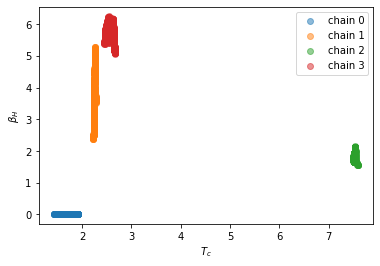

In [30]:
data = fit.extract(pars=['temp_crit', 'beta_hazard'], permuted=False)
for chain in range(4):
    plt.scatter(data['temp_crit'][:, chain], data['beta_hazard'][:, chain], label=f'chain {chain}', alpha=0.5)
    plt.legend()
plt.xlabel('$T_c$')
plt.ylabel('$\\beta_H$')

In [35]:
stan_data.keys()

dict_keys(['temp_reg', 'mat_reg', 'I', 'T', 'S', 'R', 'Y', 'temp_year', 'obs_temp', 'surv_year', 'surv_eggs', 'surv_fry', 'D', 'redd_year', 'redd_day', 'obs_redds', 'redd_length', 'redd_offset'])

In [36]:
df = pd.DataFrame(data={'temp': stan_data['obs_temp'], 'year': stan_data['temp_year']})

In [41]:
df[df['year'] == 9].describe()

,temp,year
count,14.000000,14.0
mean,10.985714,9.0
std,0.224832,0.0
min,10.500000,9.0
25%,10.900000,9.0
50%,11.000000,9.0
75%,11.150000,9.0
max,11.400000,9.0


In [45]:
a = np.array(['2004', '2005', '2006'], dtype='datetime64[D]')

In [49]:
a[0] + 366 +365

numpy.datetime64('2006-01-01')